# ISYE 6740, Homework 2
## Student: Homayoun Gerami




# Question-1:  Political blogs dataset 

## 1-1 Assume the number of clusters in the graph isk.  Explain the meaning of k here intuitively.

K referes to the number of clusters or groups, that the member of each group have considerable interconnections. The groups may or may not be conncted, but if connected the degree of connections are far less than the connection within a group.     

##  1-2 Use spectral clustering to find the k= 2, 5, 10, 20 clusters in the network of political blogs (each node is a blog, and their edges are defined in the fileedges.txt).  Then report the majority labels in each cluster, for different k values, respectively.  For example, if there are k= 2 clusters, and their labels are {0,1,1,1} and {0,0,1} then the majority label for the first cluster is 1 and for the secondcluster is 0. It is required you implementing the algorithms yourself rather than calling from a package.

##  1-3 Now compare the majority label with the individual labels in each cluster, and report the mismatch rate for each cluster, whenk= 2, 5, 10, 20.  For instance, in the example above, the mismatchrate for the first cluster is 1/4 (only the first node differs from the majority) and the the second clusteris 1/3.

I have attempted to answer both 1-2 & 1-3 together:
 - loaded the nodes & edges csv files
 - dropped nodes with no edges
 - since our case is a undirectional case, I hence updated the edges irrepstives of directions and dropped the duplicated ones.
 - I used coordinate sparse matrix, COO, for, better storage and effeiciet code running
 - Established Adjaceney matrix, $A$, Degree Matrix , $D$ and Laplacian Matrix $L$
 - Derived Eigen Values & Eigen Vecotrs for the $L$ and sort them in ascending order
 - Perfored K-mean with different values
 - Calculated the required statistics for answering 1-2 and 1-3
 
 ### I tried both eigen decomp. and SVD approaches for this question and I think the SVD produced more reliable results. I have reported both results below:


### 1) Spectral Clustering using Eigen Decomp. apprach:

In [1]:
import pandas as pd
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.cluster import KMeans

Loading the nodes and edges; there are 1490 nodes but only 1224 of them are connected.

In [2]:
nodes_all = pd.read_csv("nodes.txt", sep="\t", header=None, names=["name", "Blog_link","label", "Blog_source"])
nodes_all

,name,Blog_link,label,Blog_source
0,1,100monkeystyping.com,0,Blogarama
1,2,12thharmonic.com/wordpress,0,BlogCatalog
2,3,40ozblog.blogspot.com,0,"Blogarama,BlogCatalog"
3,4,4lina.tblog.com,0,Blogarama
4,5,750volts.blogspot.com,0,Blogarama
...,...,...,...,...
1485,1486,youngconservative.blogspot.com,1,Blogarama
1486,1487,zebrax.blogs.com,1,BlogCatalog
1487,1488,zeke01.blogspot.com,1,"Blogarama,BlogCatalog"
1488,1489,zeke01.typepad.com,1,Blogarama


In [3]:
edges = pd.read_csv("edges.txt", sep="\t", header=None, names=["org", "dest"])
edges

,org,dest
0,267,1394
1,267,483
2,267,1051
3,904,1479
4,904,919
...,...,...
19085,1133,1390
19086,1133,1429
19087,1133,1423
19088,1133,1408


In [4]:
dest_nodes=list(edges['dest'])
org_nodes=list(edges['org'])
org_nodes.extend(dest_nodes)
active_nodes=set(org_nodes)
active_nodes_list=list(active_nodes)
len(active_nodes_list)


1224

In [5]:
active_nodes_df=nodes_all[nodes_all['name'].isin(active_nodes_list)]
active_nodes_df.reset_index(inplace = True, drop=True)
active_nodes_df

,name,Blog_link,label,Blog_source
0,1,100monkeystyping.com,0,Blogarama
1,2,12thharmonic.com/wordpress,0,BlogCatalog
2,5,750volts.blogspot.com,0,Blogarama
3,6,95theses.blogspot.com,0,Blogarama
4,7,abbadabbaduo.blogspot.com,0,"Blogarama,LeftyDirectory"
...,...,...,...,...
1219,1486,youngconservative.blogspot.com,1,Blogarama
1220,1487,zebrax.blogs.com,1,BlogCatalog
1221,1488,zeke01.blogspot.com,1,"Blogarama,BlogCatalog"
1222,1489,zeke01.typepad.com,1,Blogarama


In [6]:
label_mappings = {m: n for m,n in zip(nodes_all['name'],nodes_all['label']) }
#label_mappings

In [7]:
#edges2= edges.drop_duplicates()
#edges2

In [8]:
from pandas import concat

edges_transpose = edges.rename(columns={'org': 'dest', 'dest': 'org'})
edges_all = concat([edges, edges_transpose], sort=False) \
                .drop_duplicates() \
                .reset_index(drop=True)

edges_all

,org,dest
0,267,1394
1,267,483
2,267,1051
3,904,1479
4,904,919
...,...,...
33428,1269,1133
33429,1390,1133
33430,1429,1133
33431,1408,1133


### establish our $A$ matrix
which is called A_blogs

In [9]:
### I have used a modified version of the COO function from the course 6040
def df_to_coo(nodes, edges):

    from scipy.sparse import coo_matrix  
    
    n = nodes.index.max() + 1
    name_to_id = dict(zip(nodes['name'], nodes.index))
    
    values = [1.0] * len(edges)
    rows = edges['org'].replace(name_to_id)
    cols = edges['dest'].replace(name_to_id)
    return coo_matrix((values, (rows, cols)), shape=(n, n))

    
A_blogs = df_to_coo(active_nodes_df, edges_all)


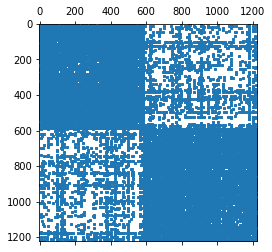

In [10]:
import matplotlib.pylab as plt
plt.spy(A_blogs, markersize=2)

### Established our Degree, $D$, AND  Laplacian, $L$, matrices


In [11]:
def calc_degrees_matrix(A):
    from scipy.sparse import spdiags
    n = min(A.shape)
    return spdiags(A.sum(axis=1).reshape(n), diags=0, m=A.shape[0], n=A.shape[1])
D=calc_degrees_matrix(A_blogs)

In [12]:
D.todense()

matrix([[26.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0., 45.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  4., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0., 18.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [13]:
#Laplacian Matrix
L=D-A_blogs

### Calculated Eigen Values and Vectors

In [14]:
eigen_vals, eigen_vecs = np.linalg.eigh(L.todense())

Sort eigenvector in ascending order by eigenvalue

In [15]:
# Sort eigenvector in ascending order by eigenvalue

idx = eigen_vals.argsort()
eigen_vals = eigen_vals[idx]

eigen_vecs = eigen_vecs[idx]

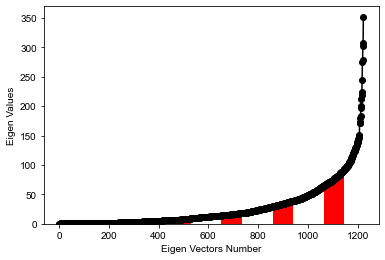

In [16]:
plt.bar(np.arange(len(eigen_vals)),eigen_vals,  width = 0.4, color ='red')
plt.style.use('seaborn-whitegrid')
plt.plot(eigen_vals,'-ok')
plt.xlabel("Eigen Vectors Number") 
plt.ylabel("Eigen Values")
plt.show()

Text(0, 0.5, 'Eigen Values')

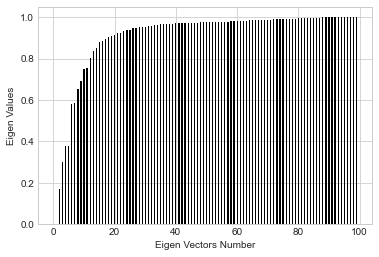

In [17]:
plt.bar(np.arange(len(eigen_vals[0:100])),eigen_vals[0:100],  width = 0.4, color ='black')
plt.xlabel("Eigen Vectors Number") 
plt.ylabel("Eigen Values")

### Performed k-means clustering on the k combined eigen vectors: 

In [18]:
from scipy.cluster import vq
#centers_vq, distortion_vq = vq.kmeans(eigen_vecs[:,:2], 2)
#clustering_vq, _ = vq.vq(eigen_vecs[:,:10], centers_vq)
kmeans = KMeans(n_clusters=2,init='random').fit(eigen_vecs[:,:2])
clustering = kmeans.labels_

In [19]:
#clustering_vq
clustering

array([0, 0, 0, ..., 0, 0, 0])

In [20]:
nodes_labels= active_nodes_df['label']


In [21]:
K=2
labels_In_each_cluster={}
nodes_In_each_cluster={}
for k in range(K):
    labels_In_each_cluster[k]=[]
    #for i,m in enumerate (clustering_vq):
    for i,m in enumerate (clustering):    
        if m==k:
            labels_In_each_cluster[k].append(nodes_labels[i])



In [22]:
print(labels_In_each_cluster)

{0: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Out of the two established clusters, one only contains two nodes, representing that those two nodes are only communicating with themself, while the rest of the nodes, 1222 nodes, belong to the seocnd cluster. I derived those two nodes names, but have not removed them in this report, as my attempt for removing those point didn't produce a significat improvements. 

In [23]:
The_two_nodes = np.where(clustering== 1)
The_two_nodes

(array([148, 518], dtype=int64),)

In [24]:
active_nodes_df.iloc[[148,518],:]

,name,Blog_link,label,Blog_source
148,182,digital-democrat.blogspot.com,0,Blogarama
518,666,thelonedem.com,0,Blogarama


### The following functions derived the required statistics for answering the 1-2  & 1-3:
- Reporting the dominant label in each cluster
- To report, for each cluster, how many members are the same as the diminant member, right, and how mnay membere are different, wrong
- To calculate mis-match rate in each cluster
- and finally calculating the overall mis-match rate for the whole active nodes 

In [25]:
Dominant_Label_In_each_cluster={}
for i in labels_In_each_cluster.keys():
    Dominant_Label_In_each_cluster[i] = max(set(labels_In_each_cluster[i]), key=labels_In_each_cluster[i].count)
    

In [26]:
Dominant_Label_In_each_cluster

{0: 1, 1: 0}

In [27]:
#Right & Wrong Numbers in Each cluster
Right_or_Wrong_in_clusters={}
Mis_match_in_each_cluster={}
Wrong_counts_total=0
for i in labels_In_each_cluster.keys():
    #Dominant_Label_In_each_cluster[i] = max(set(labels_In_each_cluster[i]), key=labels_In_each_cluster[i].count)
    Right_counts= labels_In_each_cluster[i].count(Dominant_Label_In_each_cluster[i])
    Wrong_counts= len(labels_In_each_cluster[i]) - Right_counts 
    Right_or_Wrong_in_clusters[i] = [ Right_counts, Wrong_counts]
    Mis_match_in_each_cluster[i] = round(Wrong_counts / len(labels_In_each_cluster[i]),2)
    Wrong_counts_total +=Wrong_counts
    Total_MisMatch = Wrong_counts_total / (len(nodes_labels))

In [28]:
Total_MisMatch

0.47875816993464054

In [29]:
Right_or_Wrong_in_clusters

{0: [636, 586], 1: [2, 0]}

In [30]:
# once eigen vectors caclulated and ordered
def Clustering_on_eigenvecotrs(eigen_vecs,K):
    #centers, distortion = vq.kmeans(eigen_vecs[:,:K], K)
    #clustering, _ = vq.vq(eigen_vecs[:,:K], centers)
    kmeans = KMeans(n_clusters=K,init='random').fit(eigen_vecs[:,:K])
    clustering = kmeans.labels_
    return(clustering)

In [31]:
def mismatch_reporting(clustering, nodes_labels,K ):
    labels_In_each_cluster={}
    for k in range(K):
        labels_In_each_cluster[k]=[]
        for i,m in enumerate (clustering):
            if m==k:
                labels_In_each_cluster[k].append(nodes_labels[i])
    Dominant_Label_In_each_cluster={}
    for i in labels_In_each_cluster.keys():
        Dominant_Label_In_each_cluster[i] = max(set(labels_In_each_cluster[i]), key=labels_In_each_cluster[i].count)
    print('for the K={} here is the Dominant Labels in each cluster: '.format(K))
    print(Dominant_Label_In_each_cluster)
    Right_or_Wrong_in_clusters={}
    Mis_match_in_each_cluster={}
    Wrong_counts_total=0
    for i in labels_In_each_cluster.keys():
        #Dominant_Label_In_each_cluster[i] = max(set(labels_In_each_cluster[i]), key=labels_In_each_cluster[i].count)
        Right_counts= labels_In_each_cluster[i].count(Dominant_Label_In_each_cluster[i])
        Wrong_counts= len(labels_In_each_cluster[i]) - Right_counts 
        Right_or_Wrong_in_clusters[i] = [ Right_counts, Wrong_counts]
        Mis_match_in_each_cluster[i] = round(Wrong_counts / len(labels_In_each_cluster[i]),2)
        Wrong_counts_total +=Wrong_counts
        Total_MisMatch = Wrong_counts_total / (len(nodes_labels))
    
    print('calculated Mis_match in each cluster:\n ',Mis_match_in_each_cluster)
    print('and the overall Mismacth for all the clusters is:\n',round(Total_MisMatch,2))
    print('##############################################\n')
    return round(Total_MisMatch,2)


In [32]:
mismatch_reporting(clustering, nodes_labels,2 )

for the K=2 here is the Dominant Labels in each cluster: 
{0: 1, 1: 0}
calculated Mis_match in each cluster:
  {0: 0.48, 1: 0.0}
and the overall Mismacth for all the clusters is:
 0.48
##############################################



0.48

#### We have then applied the function for various Ks , K= [2,3,5,8,10,12,15,18,20,25,30]

In [33]:
Reported_Mismatch_for_K={}
for K in [2,3,5,8,10,12,15,18,20,25,30]:
    #Clustering_on_eigenvecotrs(eigen_vecs,K)
    clustering = Clustering_on_eigenvecotrs(eigen_vecs,K)
    M=mismatch_reporting(clustering, nodes_labels,K )
    Reported_Mismatch_for_K[K]=M

for the K=2 here is the Dominant Labels in each cluster: 
{0: 1, 1: 0}
calculated Mis_match in each cluster:
  {0: 0.48, 1: 0.0}
and the overall Mismacth for all the clusters is:
 0.48
##############################################

for the K=3 here is the Dominant Labels in each cluster: 
{0: 1, 1: 1, 2: 0}
calculated Mis_match in each cluster:
  {0: 0.46, 1: 0.33, 2: 0.39}
and the overall Mismacth for all the clusters is:
 0.45
##############################################

for the K=5 here is the Dominant Labels in each cluster: 
{0: 1, 1: 1, 2: 0, 3: 0, 4: 1}
calculated Mis_match in each cluster:
  {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.48}
and the overall Mismacth for all the clusters is:
 0.48
##############################################

for the K=8 here is the Dominant Labels in each cluster: 
{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 1, 6: 0, 7: 1}
calculated Mis_match in each cluster:
  {0: 0.0, 1: 0.33, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.46}
and the overall Mismacth for 

#### Reported mis-match rate for differnt K values:

In [34]:
Reported_Mismatch_for_K

{2: 0.48,
 3: 0.45,
 5: 0.48,
 8: 0.44,
 10: 0.47,
 12: 0.46,
 15: 0.45,
 18: 0.04,
 20: 0.06,
 25: 0.04,
 30: 0.05}

### 2) Spectral Clustering using SVD approach:

In [35]:
#### used modified version of the course sample code
#Adjacency matrix:
A = df_to_coo(active_nodes_df, edges_all)
#Degree Matrix
D = np.diag(1/np.sqrt(np.sum(A, axis=1)).A1)
#Laplacian Matrix:
L = D @ A @ D

In [36]:
#X: eigen vectors
#V: eigen values, descending sorted
x, v, _= np.linalg.svd(L)

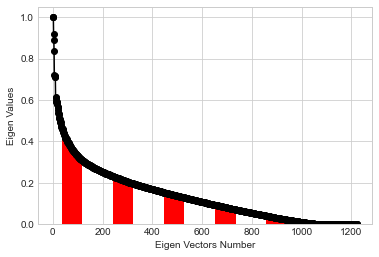

In [37]:
plt.bar(np.arange(len(v)),v,  width = 0.4, color ='red')
plt.style.use('seaborn-whitegrid')
plt.plot(v,'-ok')
plt.xlabel("Eigen Vectors Number") 
plt.ylabel("Eigen Values")
plt.show()

Text(0, 0.5, 'Eigen Values')

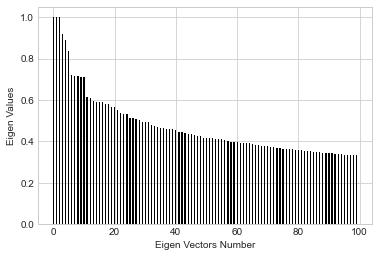

In [38]:
plt.bar(np.arange(len(v[0:100])),v[0:100],  width = 0.4, color ='black')
plt.xlabel("Eigen Vectors Number") 
plt.ylabel("Eigen Values")

In [39]:
# once eigen vectors caclulated and ordered
def Clustering_on_eigenvecotrs_2(eigen_vecs,K):
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=K,init='random').fit(eigen_vecs[:,:K])
    clustering = kmeans.labels_
    #centers, distortion = vq.kmeans(eigen_vecs[:,:K], K)
    #clustering, _ = vq.vq(eigen_vecs[:,:K], centers)
    return(clustering)

In [40]:
Reported_Mismatch_for_K_svd={}
for K in [2,3,5,8,10,12,15,18,20,25,30]:
    #Clustering_on_eigenvecotrs(eigen_vecs,K)
    clustering = Clustering_on_eigenvecotrs_2(x,K)
    M=mismatch_reporting(clustering, nodes_labels,K )
    Reported_Mismatch_for_K_svd[K]=M

for the K=2 here is the Dominant Labels in each cluster: 
{0: 1, 1: 1}
calculated Mis_match in each cluster:
  {0: 0.48, 1: 0.48}
and the overall Mismacth for all the clusters is:
 0.48
##############################################

for the K=3 here is the Dominant Labels in each cluster: 
{0: 0, 1: 1, 2: 1}
calculated Mis_match in each cluster:
  {0: 0.0, 1: 0.48, 2: 0.48}
and the overall Mismacth for all the clusters is:
 0.48
##############################################

for the K=5 here is the Dominant Labels in each cluster: 
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0}
calculated Mis_match in each cluster:
  {0: 0.02, 1: 0.07, 2: 0.01, 3: 0.33, 4: 0.04}
and the overall Mismacth for all the clusters is:
 0.04
##############################################

for the K=8 here is the Dominant Labels in each cluster: 
{0: 1, 1: 1, 2: 0, 3: 1, 4: 0, 5: 0, 6: 0, 7: 0}
calculated Mis_match in each cluster:
  {0: 0.2, 1: 0.02, 2: 0.01, 3: 0.05, 4: 0.0, 5: 0.0, 6: 0.07, 7: 0.0}
and the overall Mismact

## 1-4 Tune your k and find the number of clusters to achieve a reasonably small mismatch rate. Please explain how you tune k and what is the achieved mismatch rate.

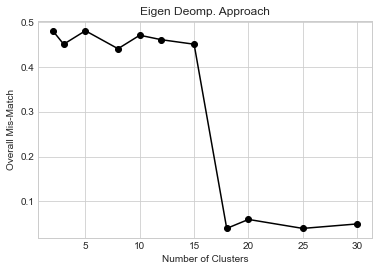

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.xlabel('Number of Clusters')
plt.ylabel('Overall Mis-Match')
plt.title("Eigen Deomp. Approach") 
plt.plot(Reported_Mismatch_for_K.keys(), Reported_Mismatch_for_K.values(), '-ok', color='black');

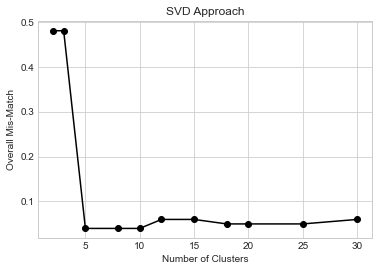

In [42]:
plt.style.use('seaborn-whitegrid')
plt.xlabel('Number of Clusters')
plt.ylabel('Overall Mis-Match')
plt.title("SVD Approach") 
plt.plot(Reported_Mismatch_for_K_svd.keys(), Reported_Mismatch_for_K_svd.values(), '-ok', color='black');

### I have tested Eigen Decomp. and SVD approaches and ploted the mis-mathes in respect with K values for both approaches. I think the SVD approach produced more trustworthy results. The plot for this approach make a better sense to me, also there are reported issues for the Eigen Decomp. performance for the smallest eigen values and vecotrs. I hence based on the results I think number of clusters between 5-15 might be a good choice.  

## 1-5 Please explain the finding and what can you learn from this data analysis.

### These are my observation and findings after doing question-1:
- As it was earlier mentioned by prof, I also think that SVD is more reliable to derive sorted eigen values and capturing the **highest** values than the Eigen Decomp. for capturing the **lowest**. The derived mis-match via these two approaches suggest that.
- As expected the result of k-mean clustering, as the initial points were radnomly selected, are not unique and hence after each repeat the results slightly varies. I attempted to conisder this effect and reported sort of averaged statistics. 
- Mis-match rate in general was reduced as we go from very low number of clusters to higher numbers, but I noticed that didn't mean that this reduction would continue forever and I observed a resverse effect for cluster numbers more than 20. 
- In this particlualr dataset, we had nodes from two major political gropus, maybe then the first execpection was the two clusters may perform a releatively good job, but that was not the case, even when I removed the two nodes that were only in communication with themself, I oberved that two or three clusters didn't produce a satisfcatory reuslts. That suggestes there were considerable connections even between the major parties and also nodes from same parties may have some political disagreements, or considerable connection with oppostions.    


# Question-2: Eigenfaces and simple face recognition

## 2-1 Perform analysis on the Yale face dataset for Subject 1 and Subject 2, respectively, using all the images EXCEPT for the two pictures named subject01-test.gif and subject02-test.gif. Plot the first 6 eigenfaces for each subject. When visualizing, please reshape the eigenvectors into proper images.  Please explain can you see any patterns in the top 6 eigenfaces?

In [43]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import math
import scipy

In [44]:
def read_image(file_path):
    return Image.open(file_path)

def downsample_image(image):
    w, h = image.size

    image.thumbnail((math.ceil(w/4), math.ceil(h/4)))
    return image

def preprocess_image(file_path):
    image = read_image(file_path)
    downsampled_image = downsample_image(image)
    return downsampled_image

def get_image_data(image):
    return np.array(image)

def list_files(directory):
    return [f for f in listdir(directory) if isfile(join(directory, f))]

In [45]:
subject_1 = []
subject_2 = []
for file in list_files("data/yalefaces/"):
    if file == 'subject01-test.gif' or file == 'subject02-test.gif':
        continue
    im = preprocess_image("data/yalefaces/" + file)
    im_dat = get_image_data(im).flatten()
    if 'subject01' in file:
        subject_1.append(im_dat)
    else:
        subject_2.append(im_dat)
    
subject_1 = np.vstack(subject_1)
subject_2 = np.vstack(subject_2)

In [46]:
Subject01_00=Image.open('data\yalefaces\subject01.glasses.gif')

In [47]:
Subject01_00.size

(320, 243)

In [48]:
width, height= Subject01_00.size

In [49]:
w, h=math.ceil(width/4), math.ceil(height/4)

### Subject-1 related 10 gifs:

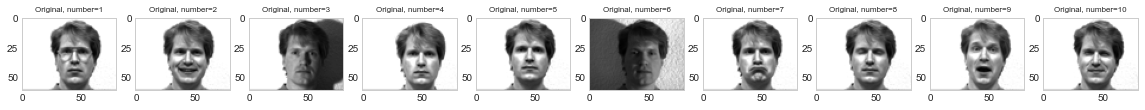

In [67]:
plt.rcParams["axes.grid"] = False
f, axarr=plt.subplots(1,10,figsize=(20,30))
for i in range(10):   
    #plt.subplots(1,i,figsize=(3,4))
    axarr[i].imshow(subject_1[i].reshape((h, w)),cmap = 'gray')
    axarr[i].set_title("Original, number=%i" %(i+1),fontsize=8 )

### Subject-2 related 10 gifs:

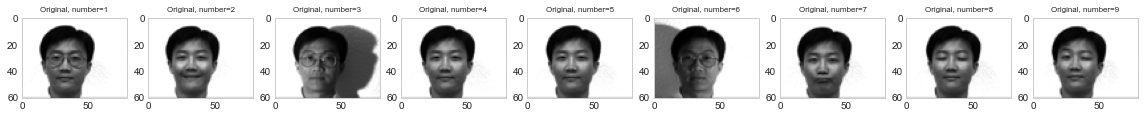

In [68]:
f, axarr=plt.subplots(1,9,figsize=(20,30))
for i in range(9):   

    axarr[i].imshow(subject_2[i].reshape((h, w)),cmap = 'gray')
    axarr[i].set_title("Original, number=%i" %(i+1),fontsize=8 )

In [69]:
mean_subject_1 = np.mean(subject_1, axis=0)
mean_subject_2 = np.mean(subject_2, axis=0)
centered_subject_1 = subject_1-mean_subject_1
centered_subject_2 = subject_2-mean_subject_2

Text(0.5, 1.0, 'Mean Subject-2')

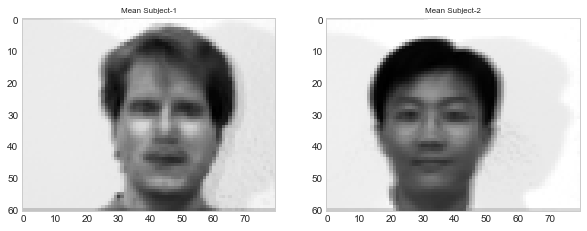

In [70]:
f, axarr=plt.subplots(1,2,figsize=(10,15))
axarr[0].imshow(mean_subject_1.reshape((h, w)),cmap = 'gray')
axarr[0].set_title("Mean Subject-1",fontsize=8 )
axarr[1].imshow(mean_subject_2.reshape((h, w)),cmap = 'gray')
axarr[1].set_title("Mean Subject-2",fontsize=8 )

### Calculating the Eigenfaces using Eigen Decomp. :

In [71]:
C1 = np.cov(centered_subject_1, rowvar=False)

In [72]:
#E1, U1 = np.linalg.eigh(C1)
E1, U1 = np.linalg.eig(C1)
E1, U1 = E1.real , U1.real

In [73]:
idc1 = np.argsort(-E1)
#print(idc1[:9])    # first 9 indices Descending Order
#print(E1[idc1][:9]) # first 9 sorted eigenvalues

In [74]:
E1 = E1[idc1]
U1 = U1[:,idc1] # sort columns

In [75]:
U1 = U1[:,:6] # consider the last six largest eigenvectors
#Y1 = np.dot(U1.T,centered_subject_1) # project data on these eigenvectors
print (U1.shape)

(4880, 6)


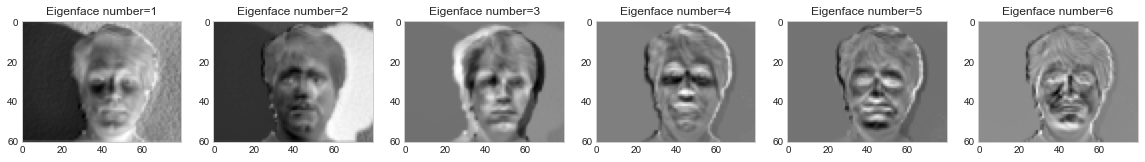

In [76]:
n_eigenfaces=6
#eigenfaces_subject_1=Y1[:n_eigenfaces,:].reshape(n_eigenfaces,h,w)

f, axarr=plt.subplots(1,n_eigenfaces,figsize=(20,30))
for i in range(n_eigenfaces):
    #axarr[i].imshow(eigenfaces_subject_1[:,i].reshape((h, w)),cmap = 'gray')
    axarr[i].imshow(U1[:,i].reshape((h, w)),cmap = 'gray')
    axarr[i].set_title("Eigenface number=%i" %(i+1))

In [77]:
#### sanity check of eigenvectors U1:
U1[:,0].shape

(4880,)

In [78]:
U1[:,0].T@U1[:,1]

6.192962809237201e-16

In [79]:
U1[:,0].T@U1[:,0]

1.0

In [80]:
##### Sanity check was succesful for U1

In [81]:
C2 = np.cov(centered_subject_2, rowvar=False)

In [82]:
#E2, U2 = np.linalg.eigh(C2)
E2, U2 = np.linalg.eig(C2)
E2, U2 = E2.real , U2.real

In [83]:
idc2 = np.argsort(-E2)
#print(idc2[:9])     
#print(E2[idc2][:9])  

In [84]:
E2 = E2[idc2]
U2 = U2[:,idc2]  

In [85]:
U2 = U2[:,:6] # consider the last six ("largest") eigenvectors
#Y2 = np.dot(U2.T,centered_subject_2) # project data on these eigenvectors
#print (Y2.shape)

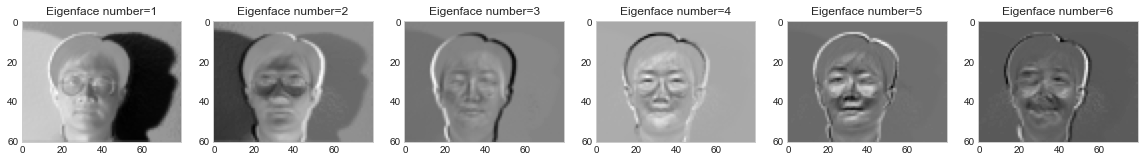

In [86]:
n_eigenfaces=6
#eigenfaces_subject_2=Y2[:n_eigenfaces,:].reshape(n_eigenfaces,h,w)

f, axarr=plt.subplots(1,n_eigenfaces,figsize=(20,30))
for i in range(n_eigenfaces):
    #axarr[i].imshow(eigenfaces_subject_2[i].reshape((h, w)),cmap = 'gray')
    axarr[i].imshow(U2[:,i].reshape((h, w)),cmap = 'gray')
    axarr[i].set_title("Eigenface number=%i" %(i+1))

In [87]:
#### sanity check eigenvectors U2:
U2[:,0].shape

(4880,)

In [88]:
U2[:,0].T@U2[:,1]

-1.9376861226660935e-15

In [89]:
U2[:,0].T@U2[:,0]

1.0000000000000002

In [90]:
##### Sanity check was succesful for U2

### Obervations on the Eigenfaces:
#### The larger eigenvectors, 1-3,  mostly contain dominant/major, and maybe common and regional, features where as other minor and detailed oriented features mostly appeared in the smaller vectors 4-6. Also I see the shaddows only in the 1st three vectors, and not in the 4-6 vectors.  

## 2-2 Now we will perform a simple face recognition task. 

## Face recognition through PCA is proceeded as follows. Given the test image subject01-test.gif and subject02-test.gif, first downsize by a factor of 4 (as before), and vectorize each image. Take the top eigenfaces of Subject 1 and Subject 2, respectively. Then we calculate the normalized inner product score of the 2 vectorized test images with the vectorized eigenfaces.

## Report all four scores: $ s_{ij}$ , $i$ = 1, 2, $j$ = 1, 2  Explain how to recognize the faces of the test images using these scores. 

In [91]:
subject_1_test_image = preprocess_image("data/yalefaces/subject01-test.gif")

subject_1_test = get_image_data(subject_1_test_image).flatten()
subject_2_test_image = preprocess_image("data/yalefaces/subject02-test.gif")
subject_2_test = get_image_data(subject_2_test_image).flatten()

subject_1_test_image.size

In [92]:
subject_1_test.shape

(4880,)

Text(0.5, 1.0, 'Subject-2 Test')

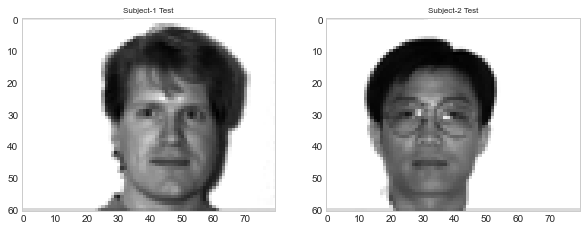

In [93]:
f, axarr=plt.subplots(1,2,figsize=(10,15))
axarr[0].imshow(subject_1_test.reshape((h, w)),cmap = 'gray')
axarr[0].set_title("Subject-1 Test",fontsize=8 )
axarr[1].imshow(subject_2_test.reshape((h, w)),cmap = 'gray')
axarr[1].set_title("Subject-2 Test",fontsize=8 )

Text(0.5, 1.0, 'Subject-2 Test minus the mean')

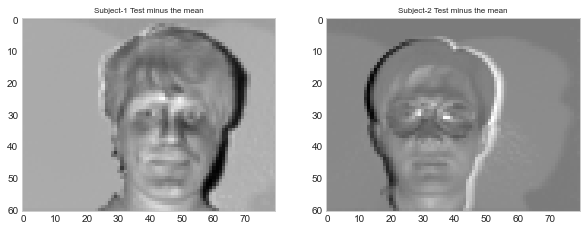

In [94]:
f, axarr=plt.subplots(1,2,figsize=(10,15))
axarr[0].imshow((subject_1_test-mean_subject_1).reshape((h, w)),cmap = 'gray')
axarr[0].set_title("Subject-1 Test minus the mean",fontsize=8 )
axarr[1].imshow((subject_2_test-mean_subject_2).reshape((h, w)),cmap = 'gray')
axarr[1].set_title("Subject-2 Test minus the mean",fontsize=8 )

In [95]:
Eigenface_Subject_1 = U1[:,0]
Eigenface_Subject_1.shape

(4880,)

In [96]:
Eigenface_Subject_2 = U2[:,0]
Eigenface_Subject_2.shape

(4880,)

### $S^{ij}$ calculation using the 1st Eigenfaces & Test images with subtracted Means:

### Score Eigenface_Subject_1 on subject_1_test (S11)

In [97]:
S11=-Eigenface_Subject_1.T @ (subject_1_test -mean_subject_1 )/ (np.linalg.norm(Eigenface_Subject_1.T) * np.linalg.norm((subject_1_test -mean_subject_1 )))
S11

0.1353301792643172

### Score Eigenface_Subject_1 on subject_2_test (S12)

In [98]:
S12=-Eigenface_Subject_1.T @ (subject_2_test -mean_subject_1)/ (np.linalg.norm(Eigenface_Subject_1.T) * np.linalg.norm((subject_2_test -mean_subject_1)))
S12

-0.269154019514262

### Score Eigenface_Subject_2 on subject_1_test (S21):

In [99]:
S21=-Eigenface_Subject_2.T @ (subject_1_test -mean_subject_2)/ (np.linalg.norm(Eigenface_Subject_2.T) * np.linalg.norm((subject_1_test -mean_subject_2)))
S21

-0.5600421496721182

### Score Eigenface_Subject_2 on subject_2_test (S22):

In [100]:
S22=-Eigenface_Subject_2.T @ (subject_2_test -mean_subject_2)/ (np.linalg.norm(Eigenface_Subject_2.T) * np.linalg.norm((subject_2_test -mean_subject_2)))
S22

0.43794152253843166

In [101]:
################ Sij calculation using the 1st Eigenfaces & Test images minus the means:
print('S11= {:.2f} , S22={:.2f}'.format(S11,S12))
print('S21= {:.2f} , S22={:.2f}'.format(S21,S22))

S11= 0.14 , S22=-0.27
S21= -0.56 , S22=0.44


### Observations:
#### I calculated the cosine similarity measure for the test subjects, with mean subtracted, and the largest eigenfaces. I had to multiply -1 into my eigenfaces for calcultion of the cosine similarity, just to have all the S numbers make some sense. That maybe an acceptable practice as the eigenvecotrs are not unique, if $\lambda$ is an eigenvector so is the -$\lambda$, and this may cause a confusion.   I had then S11 and S22 as positive numbers and S12 and S21 as negative numbers.  

#### There are other similarity measures, like residual distace calculation that doesn't  suffer from this non uniqueness confusion, I implemented that measure in the next part. 
 

## 2-3 Explain if face recognition can work well and discuss how we can improve it possibly.

##### we observed in the earlier part the non-uniqueness of the eigenvecotrs. The class was advised to test another similarity mesaure, Residual Distance, which does not suffer from this non-uniqueness issue. It simply measure the distance between any two vectors, in our case $U$ is the eigenvector and $t$ is the test imanges:  
##### Another similarity measure, Residual Distance Calculation:
$R = (I-(UU^T)*t$

##### We calculated the pair reisudal distances, $R$ : 

##### Those R numbers are always positive,  since $(-U)(-U)^T = UU^T$ , and hence I believe the residual distance measure may be more effetive than the cosine similarity measure. 

### Residual distance calculation for the EigenFaces and the test images subtracted means

In [102]:
####Residual Distance for Eigenvecotor-1 & Test Image-1
t= (subject_1_test-mean_subject_1).reshape(4880,1)
u = Eigenface_Subject_1.reshape(4880,1)

rej1_1=np.linalg.norm(t- u@u.T@t)


"{:e}".format(rej1_1)


'2.593065e+03'

In [103]:
####Residual Distance for Eigenvecotor-1 & Test Image-2
t= (subject_2_test-mean_subject_1).reshape(4880,1)
u = U1[:,0].reshape(4880,1)

rej1_2= np.linalg.norm(t- u@u.T@t)
"{:e}".format(rej1_2)

'6.315078e+03'

In [104]:
####Residual Distance for Eigenvecotor-2 & Test Image-1
t= (subject_1_test-mean_subject_2).reshape(4880,1)
u = Eigenface_Subject_2.reshape(4880,1)

rej2_1=np.linalg.norm(t- u@u.T@t)
"{:e}".format(np.linalg.norm(rej2_1))

'5.745946e+03'

In [105]:
####Residual Distance for Eigenvecotor-2 & Test Image-2
t= (subject_2_test-mean_subject_2).reshape(4880,1)
u = Eigenface_Subject_2.reshape(4880,1)

rej2_2=np.linalg.norm(t- u@u.T@t)
"{:e}".format(np.linalg.norm(rej2_2))

'1.915918e+03'

In [106]:
################ Residual Distance calculation using the  1st Eigenfaces & Test images-means:
print('Residual Distance 1_1= {:.2f} , Residual Distance 1_2= {:.2f}'.format(rej1_1,rej1_2))
print('Residual Distance 2_1= {:.2f} , Residual Distance 2_2= {:.2f}'.format(rej2_1,rej2_2))

Residual Distance 1_1= 2593.07 , Residual Distance 1_2= 6315.08
Residual Distance 2_1= 5745.95 , Residual Distance 2_2= 1915.92


#### The above number now make sense, and there is also no confusion regarding the non-uniqueness.   

#### I also extended this measure to the other Eignevectors, I had six of them for each image, and investigated if any of the eigenvecotor could further minimize such Distace:  

In [107]:
def Min_residual_distance_all(eigenfaces, subject,k):
    
    subject_r=subject.reshape(4880,1)
    distance ={}
    sum_distance=0
    for i in range(0,k):
        
        eigenface_temp =eigenfaces[:,i].reshape((4880,1))
        #eigenface_temp =eigenfaces[:,i]
        
        #sum_distance = (np.linalg.norm ( (I-(eigenface_temp@eigenface_temp.T))@subject ))
        sum_distance= subject_r- eigenface_temp@eigenface_temp.T @ subject_r
        distance[i]= np.linalg.norm(sum_distance)

    return sorted(distance.values())

In [108]:
M_D11 = Min_residual_distance_all(U1, (subject_1_test-mean_subject_1),6)
M_D11

[2507.7625956707757,
 2550.3144922676306,
 2593.065153883437,
 2601.1557767442546,
 2603.970173752224,
 2611.3291033537066]

In [109]:
M_D12 = Min_residual_distance_all(U1, (subject_2_test-mean_subject_1),6)
M_D12

[6206.847720669171,
 6315.0784362187305,
 6518.615718319646,
 6531.045832609504,
 6531.8804991627685,
 6540.185714496218]

In [110]:
M_D21 = Min_residual_distance_all(U2, (subject_1_test-mean_subject_2),6)
M_D21

[5745.946161748096,
 6830.395143230939,
 6901.76103044426,
 6918.605287771121,
 6919.353618522969,
 6933.847073875485]

In [111]:
M_D22 = Min_residual_distance_all(U2, (subject_2_test-mean_subject_2),6)
M_D22

[1751.9347247367537,
 1915.9176833085469,
 2074.2581945208353,
 2120.5050889453278,
 2121.501775819062,
 2129.5074063285806]

In [112]:
################ Residual Distance calculation using ALL the Eigenfaces & Test images-means:
print('Ultimate Residual Distance 1_1= {:.2f} , Ultimate Residual Distance 1_2= {:.2f}'.format(min(M_D11),min(M_D12) ))
print('Ultimate Residual Distance 2_1= {:.2f} , Ultimate Residual Distance 2_2= {:.2f}'.format(min(M_D21),min(M_D22)))

Ultimate Residual Distance 1_1= 2507.76 , Ultimate Residual Distance 1_2= 6206.85
Ultimate Residual Distance 2_1= 5745.95 , Ultimate Residual Distance 2_2= 1751.93


### Conclusion:
#### The above numbers provide further confidence in such face recognition practice. I looked in all the eigenvectors and observed that the minimum distance numbers are associated with either 1st or 2nd eigenface. The results also make sense in linking the relevant eigenface &  test-image.   